# Assessment of Embedded AI Solutions with the Green Software Measurement Model

In [1]:
import pandas
import seaborn
import enum
import matplotlib.pyplot as plt

Numeric labels and their corresponding names for the dataset

In [2]:
class Model(enum.IntEnum):
    EfficientNetv2 = 0
    YOLOv2 = 1


class System(enum.IntEnum):
    Coral = 0
    Jetson = 1
    GeforcePC = 2


## Dataset loading
https://doi.org/10.57967/hf/3477

In [3]:
data = pandas.read_parquet("hf://datasets/ykgmfq/gsmm_ai/data.parquet")
data.describe(percentiles=[])

,Start Time [ns],End Time [ns],Power [W],Voltage [V],Current [A],System,Model,Epoch,Chunk Size
count,3.718000e+05,3.718000e+05,371800.000000,371800.000000,371800.000000,371800.000000,371800.000000,371800.000000,371800.000000
mean,8.051577e+12,8.051812e+12,164.946365,227.129654,0.776008,1.169984,0.538999,634.093868,145.131791
std,4.875290e+12,4.875309e+12,201.500031,1.115319,0.846497,0.749498,0.498477,1120.579935,170.337430
min,0.000000e+00,1.771517e+08,5.871600,224.000000,0.061000,0.000000,0.000000,0.000000,25.000000
50%,7.839012e+12,7.839172e+12,17.018000,227.000000,0.176000,1.000000,1.000000,126.000000,25.000000
max,1.955678e+13,1.955709e+13,500.691010,230.000000,2.180000,2.000000,1.000000,4499.000000,500.000000


In [4]:
for sys, sysdata in data.groupby("System"):
    for model, modeldata in sysdata.groupby("Model"):
        print(
            f"{Model(model).name:15} on {System(sys).name:10}: {len(modeldata)} data points"
        )

EfficientNetv2  on Coral     : 48000 data points
YOLOv2          on Coral     : 30200 data points
EfficientNetv2  on Jetson    : 72000 data points
YOLOv2          on Jetson    : 80200 data points
EfficientNetv2  on GeforcePC : 51400 data points
YOLOv2          on GeforcePC : 90000 data points


## Data processing

### Energy

In [5]:
energies = []
for _, sysdata in data.groupby("System"):
    for _, modeldata in sysdata.groupby("Model"):
        # Riemann sum
        dt = modeldata["Start Time [ns]"].diff() * 1e-9
        dt.iloc[0] = 0
        energy = modeldata["Power [W]"] * dt
        energies.append(energy)
data["Energy [J]"] = pandas.concat(energies)
data["Energy [J]"].describe(percentiles=[])

count    371800.000000
mean         37.293679
std          72.741135
min           0.000000
50%           4.231124
max        1282.084522
Name: Energy [J], dtype: float64

### Chunks

In [6]:
m_chunks = data["Start Time [ns]"] // (3 * 60 * 1e9)
m_chunks = m_chunks.astype(int)
m_chunks.describe()
data["Chunk"] = m_chunks
print(f"{len(data)} data points")

371800 data points


Strip first and last chunk

In [7]:
data = data[data["Chunk"] != 0]
print(f"Without first chunk: {len(data)} data points")
for _, sysdata in data.groupby("System"):
    for _, modeldata in sysdata.groupby("Model"):
        m_chunks = modeldata["Chunk"]
        last = m_chunks[m_chunks == m_chunks.iloc[-1]].index
        data = data.drop(last)
print(f"Without last chunk:  {len(data)} data points")

Without first chunk: 367352 data points
Without last chunk:  365198 data points


### Extracted data

In [8]:
ee_f = []
sample_f = []
for sys_idx, sysdata in data.groupby("System"):
    sysname=System(sys_idx).name
    for m_idx, modeldata in sysdata.groupby("Model"):
        mname=Model(m_idx).name
        for chunk, chunkdata in modeldata.groupby("Chunk"):
            # Cumulative samples
            samples = chunkdata["Chunk Size"].cumsum().iloc[-1]
            # Cumulative energy
            acc = chunkdata["Energy [J]"].cumsum().iloc[-1]
            # Energy efficiency factor
            tot = samples / acc
            ee_f.append((sysname, Model(m_idx).name, chunk, tot))
            # Cumulative time
            start = chunkdata["Start Time [ns]"].min()
            end = chunkdata["End Time [ns]"].max()
            tt = (end - start) * 1e-9
            tt = samples / tt
            sample_f.append((sysname, mname, chunk, tt))
ee_f = pandas.DataFrame(
    ee_f,
    columns=["System", "Model", "Chunk", "Energy efficiency factor [1/J]"],
)
sample_f = pandas.DataFrame(
    sample_f,
    columns=["System", "Model", "Chunk", "Sample factor [1/s]"],
)
ee_f

,System,Model,Chunk,Energy efficiency factor [1/J]
0,Coral,EfficientNetv2,1,9.949974
1,Coral,EfficientNetv2,2,9.913525
2,Coral,EfficientNetv2,3,9.904142
3,Coral,EfficientNetv2,4,9.791521
4,Coral,EfficientNetv2,5,9.721728
...,...,...,...,...
537,GeforcePC,YOLOv2,80,4.374292
538,GeforcePC,YOLOv2,81,4.490342
539,GeforcePC,YOLOv2,82,4.384989
540,GeforcePC,YOLOv2,83,4.357371


In [9]:
sample_f

,System,Model,Chunk,Sample factor [1/s]
0,Coral,EfficientNetv2,1,69.760724
1,Coral,EfficientNetv2,2,70.150104
2,Coral,EfficientNetv2,3,69.940953
3,Coral,EfficientNetv2,4,69.561862
4,Coral,EfficientNetv2,5,69.948916
...,...,...,...,...
537,GeforcePC,YOLOv2,80,1430.465202
538,GeforcePC,YOLOv2,81,1492.804053
539,GeforcePC,YOLOv2,82,1526.905213
540,GeforcePC,YOLOv2,83,1484.218901


Mean energy efficiency factor

In [10]:
for sys, sysdata in ee_f.groupby("System"):
    for model, modeldata in sysdata.groupby("Model"):
        mean=modeldata["Energy efficiency factor [1/J]"].mean()
        print(
            f"{model:15} on {sys:10}: {mean:05.2f}"
        )

EfficientNetv2  on Coral     : 09.63
YOLOv2          on Coral     : 06.71
EfficientNetv2  on GeforcePC : 03.21
YOLOv2          on GeforcePC : 04.37
EfficientNetv2  on Jetson    : 05.90
YOLOv2          on Jetson    : 11.38


Mean sample factor

In [11]:
for sys, sysdata in sample_f.groupby("System"):
    for model, modeldata in sysdata.groupby("Model"):
        mean=modeldata["Sample factor [1/s]"].mean()
        print(
            f"{model:15} on {sys:10}: {mean:04.0f}"
        )

EfficientNetv2  on Coral     : 0069
YOLOv2          on Coral     : 0045
EfficientNetv2  on GeforcePC : 1315
YOLOv2          on GeforcePC : 1468
EfficientNetv2  on Jetson    : 0100
YOLOv2          on Jetson    : 0166


## Plots


### Energy efficiency factor

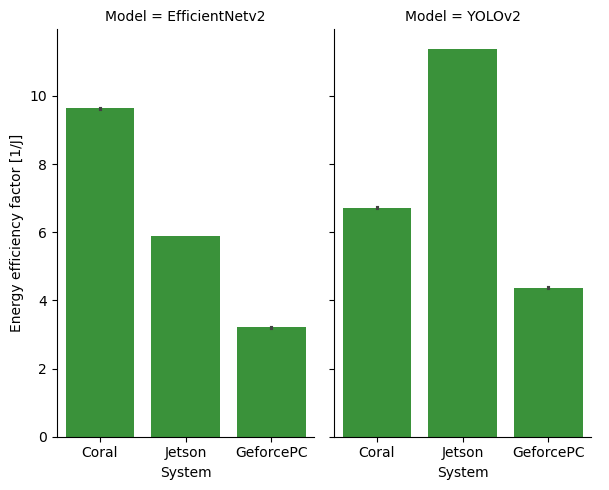

In [12]:
ax = seaborn.catplot(
    ee_f,
    kind="bar",
    x="System",
    y="Energy efficiency factor [1/J]",
    col="Model",
    aspect=0.6,
    color=seaborn.color_palette("tab10")[2]
)
plt.tight_layout()
plt.savefig("eef.pdf")

### Sample factor

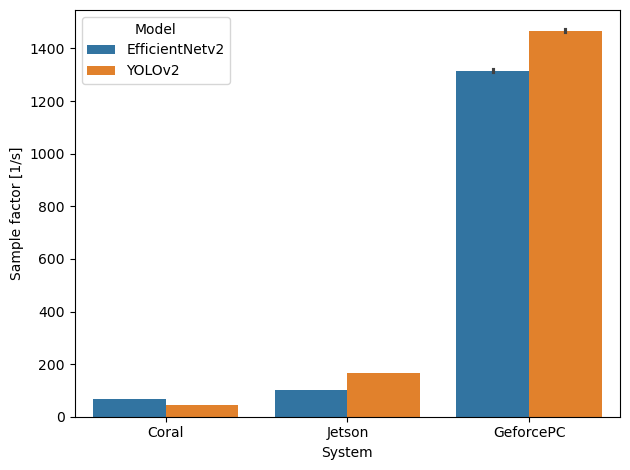

In [13]:
ax = seaborn.barplot(
    sample_f,
    x="System",
    y="Sample factor [1/s]",
    hue="Model",
)
plt.tight_layout()
plt.savefig("timef.pdf")